<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notebook-setup" data-toc-modified-id="Notebook-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notebook setup</a></span></li><li><span><a href="#Import-data" data-toc-modified-id="Import-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import data</a></span><ul class="toc-item"><li><span><a href="#UK-Biobank-mCA-calls" data-toc-modified-id="UK-Biobank-mCA-calls-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>UK Biobank mCA calls</a></span></li><li><span><a href="#Inferred-s-and-mu-values" data-toc-modified-id="Inferred-s-and-mu-values-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Inferred s and mu values</a></span><ul class="toc-item"><li><span><a href="#Both-sexes-together" data-toc-modified-id="Both-sexes-together-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Both sexes together</a></span></li><li><span><a href="#Sex-specific" data-toc-modified-id="Sex-specific-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Sex-specific</a></span></li></ul></li></ul></li><li><span><a href="#Functions" data-toc-modified-id="Functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#Functions-for-calculating-degree-of-deviation-in-age-dependence" data-toc-modified-id="Functions-for-calculating-degree-of-deviation-in-age-dependence-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Functions for calculating degree of deviation in age dependence</a></span></li><li><span><a href="#Functions-for-calculating-degree-of-deviation-in-age-dependence,-if-including-more-than-1-mCA" data-toc-modified-id="Functions-for-calculating-degree-of-deviation-in-age-dependence,-if-including-more-than-1-mCA-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Functions for calculating degree of deviation in age dependence, if including more than 1 mCA</a></span></li><li><span><a href="#Functions-for-plotting-degree-of-deviation-in-age-dependence" data-toc-modified-id="Functions-for-plotting-degree-of-deviation-in-age-dependence-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Functions for plotting degree of deviation in age dependence</a></span></li></ul></li><li><span><a href="#Deviation-from-expected-age-dependence-(Figure-3d)" data-toc-modified-id="Deviation-from-expected-age-dependence-(Figure-3d)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Deviation from expected age dependence (Figure 3d)</a></span><ul class="toc-item"><li><span><a href="#Can-decline-in-prevalence-with-age-for-some-mCAs-be-explained-by-acquisition-of-additional-mCAs?-(Supplementary-Figure-19)" data-toc-modified-id="Can-decline-in-prevalence-with-age-for-some-mCAs-be-explained-by-acquisition-of-additional-mCAs?-(Supplementary-Figure-19)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Can decline in prevalence with age for some mCAs be explained by acquisition of additional mCAs? (Supplementary Figure 19)</a></span></li></ul></li></ul></div>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Notebook setup

In [2]:
# imported packages
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import scipy
from scipy import integrate
from scipy.interpolate import interp1d
from datetime import datetime
import zipfile

In [3]:
plt.style.use('cwpython.mplstyle') #use custom style file

In [4]:
#define the colors from colorbrewer2
orange1 = '#feedde'
orange2 = '#fdbe85'
orange3 = '#fd8d3c'
orange4 = '#e6550d'
orange5 = '#a63603'
blue1 = '#eff3ff'
blue2 = '#bdd7e7'
blue3 = '#6baed6'
blue4 = '#3182bd'
blue5 = '#08519c'
green1 = '#edf8e9'
green2 = '#bae4b3'
green3 = '#74c476'
green4 = '#31a354'
green5 = '#006d2c'
grey1 = '#f7f7f7'
grey2 = '#cccccc'
grey3 = '#969696'
grey4 = '#636363'
grey5 = '#252525'
purple1 = '#f2f0f7'
purple2 = '#cbc9e2'
purple3 = '#9e9ac8'
purple4 = '#756bb1'
purple5 = '#54278f'
red1 = '#fee5d9'
red2 = '#fcae91'
red3 = '#fb6a4a'
red4 = '#de2d26'
red5 = '#a50f15'

In [5]:
neutral_color='#fdbf6f'
gain_color = '#e31a1c'
loss_color = '#a6cee3'

In [6]:
male_gain_color = '#650913'
female_gain_color = gain_color
male_loss_color = '#213468'
female_loss_color = '#6badd6'
male_neutral_color = '#cb4e27'
female_neutral_color = neutral_color

In [75]:
colors_dict_mCAs = {'+': {'male': male_gain_color, 'female': female_gain_color}, 
                    '-': {'female': female_loss_color, 'male': male_loss_color},
                   '=': {'male': male_neutral_color, 'female': female_neutral_color}}

In [8]:
sex_colors_dict = {'M': 
                      {'+': 
                       {'observed': '#a50f15',
                       'expected': '#ef3b2c'},
                      '-':
                      {'observed': '#08306b',
                      'expected': '#2171b5'},
                      '=':
                      {'observed': '#993404',
                      'expected': '#ec7014'}},
                     'F':
                     {'+': 
                       {'observed': '#fb6a4a',
                       'expected': '#fcbba1'},
                      '-':
                      {'observed': '#4292c6',
                      'expected': '#9ecae1'},
                      '=':
                      {'observed': '#fe9929',
                      'expected': '#fee391'}}}

# Import data

## UK Biobank mCA calls

In [9]:
zf = zipfile.ZipFile('Data_files/Supplementary_data_annotated_cw.csv.zip') 
df_biobank = pd.read_csv(zf.open('Supplementary_data_annotated_cw.csv'))
df_biobank_known = df_biobank[df_biobank['CELL_FRAC']!='unknown'] 
df_single_mCAs = df_biobank[df_biobank['total_mCAs']==1] #create a dataframe that only contains mCAs observed as the only mCA event
df_single_mCAs.head()

,Unnamed: 0,ID,SEX,AGE,PREV_CANCER,CHR,START_MB,END_MB,SIZE_MB,BAF (SE),...,END_MB_RANGE,affects,proportion_of_chrom_or_arm,annotation,bands_involved,genes_involved,number_genes_involved,total_mCAs,persons_total_mCAs,persons_total_known_mCAs
1,1,2,M,55-60,0,1,0.84,249.16,248.32,0.0042 (0.0006),...,249.1-249.2,whole-chromosome,0.996,1=,"['1p36.33', '1p36.32', '1p36.31', '1p36.23', '...","['SGIP1', 'SLC45A1', 'NECAP2', 'CLIC4', 'AZIN2...",2611,1,['1='],['1=']
2,2,3,F,45-50,1,1,0.84,249.20,248.36,0.0034 (0.0005),...,249.2-249.2,whole-chromosome,0.996,1?,"['1p36.33', '1p36.32', '1p36.31', '1p36.23', '...","['SGIP1', 'SLC45A1', 'NECAP2', 'CLIC4', 'AZIN2...",2611,1,['1?'],[]
3,3,4,M,60-65,0,1,0.75,249.22,248.47,0.0041 (0.0006),...,249.2-249.2,whole-chromosome,0.997,1?,"['1p36.33', '1p36.32', '1p36.31', '1p36.23', '...","['SGIP1', 'SLC45A1', 'NECAP2', 'CLIC4', 'AZIN2...",2616,1,['1?'],[]
5,5,6,F,65-70,0,1,0.75,249.21,248.46,0.0039 (0.0007),...,249.2-249.2,whole-chromosome,0.997,1?,"['1p36.33', '1p36.32', '1p36.31', '1p36.23', '...","['SGIP1', 'SLC45A1', 'NECAP2', 'CLIC4', 'AZIN2...",2616,1,['1?'],[]
6,6,7,M,65-70,0,1,0.75,249.22,248.47,0.0030 (0.0005),...,249.2-249.2,whole-chromosome,0.997,1?,"['1p36.33', '1p36.32', '1p36.31', '1p36.23', '...","['SGIP1', 'SLC45A1', 'NECAP2', 'CLIC4', 'AZIN2...",2616,1,['1?'],[]


## Inferred s and mu values

### Both sexes together

In [10]:
#s and mu values inferred from MLE
mCA_s_mu = pd.read_csv('Data_files/mCA_s_mu_with_confidence_intervals_individual_mCAs.txt', sep = '\t')
mCA_s_mu = mCA_s_mu.set_index('mCA')
mCA_s_mu_dict = pd.DataFrame.to_dict(mCA_s_mu, orient = 'index')

### Sex-specific

In [11]:
#sex-specific s and mu values inferred from MLE
sex_specific_s_mu = pd.read_csv('Data_files/mCA_s_mu_with_confidence_intervals_sex_differences.txt', sep = '\t')
sex_specific_s_mu = sex_specific_s_mu.set_index('mCA')
sex_specific_s_mu_dict = pd.DataFrame.to_dict(sex_specific_s_mu, orient = 'index')

In [12]:
#create a list for each mCA class of each of the mCAs that had enough data (>=10) to infer a sex-specific mCA fitness and mutation rate
gains_list_male = []
losses_list_male = []
CNLOH_list_male = []

gains_list_female = []
losses_list_female = []
CNLOH_list_female = []

for k, v in sex_specific_s_mu_dict.items():
    if v['N_women']>=10:
        if k[-1]=='+':
            gains_list_female.append(k)
        if k[-1]=='-':
            losses_list_female.append(k)
        if k[-1]=='=':
            CNLOH_list_female.append(k)
    if v['N_men']>=10:
        if k[-1]=='+':
            gains_list_male.append(k)
        if k[-1]=='-':
            losses_list_male.append(k)
        if k[-1]=='=':
            CNLOH_list_male.append(k)

In [13]:
#create a list for each mCA class of the mCAs that were observed 30 or more times in men and 30 or more times in women
gains_30_or_more = []
losses_30_or_more = []
CNLOH_30_or_more = []
for k, v in sex_specific_s_mu_dict.items():
    female_n = v['N_women']
    male_n = v['N_men']
    if (female_n >= 30) and (male_n >=30):
        if k[-1]=='+':
            gains_30_or_more.append(k)
        if k[-1]=='-':
            losses_30_or_more.append(k)
        if k[-1]=='=':
            CNLOH_30_or_more.append(k)
            
print('gains seen in 30 or more men and 30 or more women = ', gains_30_or_more)
print('losses seen in 30 or more men and 30 or more women = ', losses_30_or_more)
print('CNLOH seen in 30 or more men and 30 or more women = ', CNLOH_30_or_more)

gains seen in 30 or more men and 30 or more women =  ['12+', '14q+', '15q+', '21q+', '22q+', '8+']
losses seen in 30 or more men and 30 or more women =  ['10q-', '11q-', '13q-', '14q-', '20q-', '2p-', '4q-', '5q-', '7q-']
CNLOH seen in 30 or more men and 30 or more women =  ['11p=', '11q=', '12q=', '13q=', '14q=', '15q=', '16p=', '16q=', '17p=', '17q=', '19p=', '19q=', '1p=', '1q=', '20q=', '21q=', '22q=', '2p=', '2q=', '3p=', '3q=', '4q=', '5q=', '6p=', '7q=', '8q=', '9p=', '9q=']


In [14]:
men_ratio = 229122/(229122+273383)
women_ratio = 273383/(229122+273383)

In [15]:
total_age_40_49 = 119000
total_age_50_59 = 168000
total_age_60_69 = 213000

# Functions

In [16]:
def filter_by_number_mCAs(number_mCAs, dataframe): #e.g. filter by those that only have 1 total mCA
    mask = dataframe['total_mCAs']==number_mCAs
    return dataframe[mask].copy()

In [17]:
def observed_numbers_by_age_sex(mCA, df, fmin, sex): #if only want single mCAs, need to filter the dataframe first
    
    df_mCA = df[df['annotation']==mCA].copy(deep = True) #filter the dataframe to only include the mCAs of interest
    df_mCA_sex = df_mCA[df_mCA['SEX']==sex].copy(deep = True) #filter the dataframe to only include the mCAs of interest
    df_mCA_sex['CELL_FRAC'] = df_mCA_sex['CELL_FRAC'].astype(float) #convert the cell fractions to floats
    min_cell_fraction = float(df_mCA_sex.min()['CELL_FRAC']) #the minimum cell fraction seen for that mCA

    df_mCA_fmin = df_mCA_sex[df_mCA_sex['CELL_FRAC']>=fmin] #filter the dataframe to only include those mCAs that are bigger than the minimum chosen cell fraction

    df_ages = {'40-45': 0, '45-50': 0, '50-55': 0, '55-60': 0, '60-65': 0, '65-70': 0} #create all the age groups (which will then get updated with the actual values if there are people in that age group)
    df_ages_mCA = df_mCA_fmin.groupby(by = ['AGE']).count()['total_mCAs'].to_dict()

    for k, v in df_ages_mCA.items():
        df_ages[k]=v #update the df_ages dictionary with the number in each age group if there is anyone in that age grou

    number_mCA_40_49 = (df_ages['40-45']+df_ages['45-50'])
    number_mCA_50_59 = (df_ages['50-55']+df_ages['55-60'])
    number_mCA_60_69 = (df_ages['60-65']+df_ages['65-70'])

    freq40_49 = number_mCA_40_49/total_age_40_49
    freq50_59 = number_mCA_50_59/total_age_50_59
    freq60_69 = number_mCA_60_69/total_age_60_69
    
    return (number_mCA_40_49, number_mCA_50_59, number_mCA_60_69), (freq40_49, freq50_59, freq60_69)

In [18]:
def expected_number_by_age_sex(mCA, fmin, sex_specific_s_mu_dict, gender):
    
    if gender == 'M':
        sex = 'male'
    if gender == 'F':
        sex = 'female'

    s = sex_specific_s_mu_dict[mCA][sex+'_s']
    u = sex_specific_s_mu_dict[mCA][sex+'_mu']

    xx=np.array([t for t in range(0,80)])
    yy=[expected_prevalence_diploid(t, u, s, fmin, mCA) for t in xx]

    age_expected = {}
    for age, expected in zip(xx, yy):
        age_expected[age]=expected

    return age_expected

In [19]:
def mCA_specfic_fmin(mCA, df): #not gender specific
    
    df_single_mCA = filter_by_number_mCAs(1, df)
    df_mCA = df_single_mCA[df_single_mCA['annotation']==mCA]
    df_mCA['CELL_FRAC'] = df_mCA['CELL_FRAC'].astype(float)
    cell_fractions = df_mCA['CELL_FRAC'].tolist()
    min_cell_frac = min(cell_fractions)
    fmin = min_cell_frac*1.5
    
    return fmin

In [20]:
def density_of_clones_diploid(f, u, s, t):
    N = 9.40166610e+04
    s = float(s)
    u = float(u)
    return ((N*u)/(f*(1-f)))*np.exp(-f/((1-f)*((np.exp(s*t)-1)/(N*s))))

In [21]:
def expected_prevalence_diploid(t, u, s, fmin, mCA): 
    N = 9.40166610e+04
    
    mCA_type = mCA[-1]
    if mCA_type == '+':
        integral_limit = 0.99999
    if mCA_type == '-':
        integral_limit = 0.67
    if mCA_type == '=':
        integral_limit = 0.54
    
    return integrate.quad(lambda f: density_of_clones_diploid(f, u, s, t), fmin, integral_limit)[0]

## Functions for calculating degree of deviation in age dependence

In [22]:
def observed_and_expected_frequencies_by_age_sex(mCA, df_single, sex_specific_s_mu_dict, fmin, sex):
    
    #OBSERVED VS EXPECTED NUMBERS
    #actual frequencies
    if sex == 'M':
        ratio = men_ratio
    if sex == 'F':
        ratio = women_ratio
        
    expected_dict = expected_number_by_age_sex(mCA, fmin, sex_specific_s_mu_dict, sex)
        
    numbers_dict = {'40-50': 0, '50-60': 0, '60-70': 0}
    numbers, freqs = observed_numbers_by_age_sex(mCA, df_single, fmin, sex)
    numbers_dict['40-50']+=numbers[0]
    numbers_dict['50-60']+=numbers[1]
    numbers_dict['60-70']+=numbers[2]
    
    expected_frequencies = {}
    observed_numbers = {}
    for k, v in numbers_dict.items():
        expected_total_for_age_range = 0
        lower_age = k.split('-')[0] #e.g. 40
        upper_age = k.split('-')[1] #e.g. 50
        mid_point = np.mean([int(lower_age), int(upper_age)])
        for age in range(int(lower_age), int(upper_age)): #will get all from 40, 41, 42, 43, 44, 45, 46, 47, 48, 49
            expected = expected_dict[age]
            expected_total_for_age_range+=expected
        expected_frequencies[mid_point]=expected_total_for_age_range/10 #is this correct to divide by 10?!
        observed_numbers[mid_point]=v

    #convert expected numbers to frequencies
    expected_numbers = {}
    expected_numbers[45.0]=expected_frequencies[45.0]*(total_age_40_49*ratio)
    expected_numbers[55.0]=expected_frequencies[55.0]*(total_age_50_59*ratio)
    expected_numbers[65.0]=expected_frequencies[65.0]*(total_age_60_69*ratio)

    print('observed_numbers = ', observed_numbers)
    print('expected_numbers = ', expected_numbers)

    
    #OBSERVED VS EXPECTED FREQUENCIES
    freq_dict = {}
    freq_dict['40-50']=numbers_dict['40-50']/(total_age_40_49*ratio)
    freq_dict['50-60']=numbers_dict['50-60']/(total_age_50_59*ratio)
    freq_dict['60-70']=numbers_dict['60-70']/(total_age_60_69*ratio)

    observed_frequencies = {}
    for k, v in freq_dict.items():
        expected_total_for_age_range = 0
        lower_age = k.split('-')[0] #e.g. 40
        upper_age = k.split('-')[1] #e.g. 50
        mid_point = np.mean([int(lower_age), int(upper_age)])
        observed_frequencies[mid_point]=v

    print('observed_frequencies = ', observed_frequencies)
    print('expected_frequencies = ', expected_frequencies)
    print()
    
    return observed_frequencies, expected_frequencies

In [23]:
def age_group_to_exclude(observed): #exclude an age group (from observed and expected) if the observed frequency is 0
    ages_to_exclude = []
    for k, v in observed.items():
        if v == 0:
            ages_to_exclude.append(k)
    
    return ages_to_exclude

In [24]:
def grid_limits(mCA, gender):
    
    grid_limits_df = pd.read_csv('Data_files/Heatmap_grid_ranges_age_dependence_deviation.txt', sep = '\t')
    
    df_mCA = grid_limits_df[grid_limits_df['mCA']==mCA]
    df_mCA_gender = df_mCA[df_mCA['gender']==gender]
    df_mCA_gender = df_mCA_gender.set_index(['mCA'])
    limits_dict = pd.DataFrame.to_dict(df_mCA_gender, orient = 'index')
    return limits_dict

In [25]:
def best_fit_line_accounting_for_error(params, age_y_list, gender, ages_to_exclude_list):
    m = params[0]
    c = params[1]
    
    if gender == 'M':
        ratio = men_ratio
    if gender == 'F':
        ratio = women_ratio
    
    total_ages = {45.0: total_age_40_49*ratio, 55.0: total_age_50_59*ratio, 65.0: total_age_60_69*ratio}
    
    sum_scaled_square_difference = 0
    
    for x, y in age_y_list.items(): #x = age, y = freq
        if x not in ages_to_exclude_list:
            total_age = total_ages[x] #total number of people in that age group
            y_fit = (m*x)+c 
            y_diff = y_fit-y #difference between frequency inferred by fitted straight line and actual frequency
            square_difference = (y_diff)**2
            scaled_square_difference = (square_difference*total_age)/(2*y) #taking in to account the error on the frequency
            sum_scaled_square_difference+=scaled_square_difference

    return sum_scaled_square_difference

In [26]:
def heatmap_line_best_fit_custom_range(age_y_list, observed_or_expected, sex, mCA, ages_to_exclude_list, m_range, c_range):
    
    labelname = mCA+' '+sex+' '+observed_or_expected
    
    #Step 1: create a new list without the excluded ages
    age_list_without_excluded = []
    y_list_without_excluded = []
    for x, y in age_y_list.items(): #x = age, y = freq
        if x not in ages_to_exclude_list:
            age_list_without_excluded.append(x)
            y_list_without_excluded.append(y)

    #Step 2: first do the best fit line, without accounting for error, to get close to the values of m and c
    best_fit_poly1d = np.polyfit(age_list_without_excluded, y_list_without_excluded, 1)
    m_initial = best_fit_poly1d[0]
    c_initial = best_fit_poly1d[1]
    
    print('initial m = ', m_initial)
    print('initial c = ', c_initial)
    
    #Step 3: now use these m and c to help guide the grid for the heatmap, but now take in to account error on the measurement
    print('m range =', m_range)
    print('c range = ', c_range)
    
    grid_size = 500

    m_list = np.linspace(m_range[0], m_range[1], grid_size) #list of possible values for m
    c_list = np.linspace(c_range[0], c_range[1], grid_size) #list of possible values for c

    #MLE
    Probs = np.array([[best_fit_line_accounting_for_error([m, c], age_y_list, sex, ages_to_exclude_list) for m in m_list] for c in c_list])

    # Plot the density map using nearest-neighbor interpolation
    x1 = m_list
    y1 = c_list
    x1, y1 = np.meshgrid(x1, y1)
    Probs_m = (-Probs)
    max_x, max_y = np.unravel_index(np.argmax(Probs_m), Probs_m.shape)
    z_max = Probs_m[max_x, max_y]
    z1 = np.exp(Probs_m)

    # calculate best values for s and mu (max points in 3D space (x,y,z))
    xmax, ymax = np.unravel_index(np.argmax(z1), z1.shape)
    c_max = y1[xmax, ymax]
    m_max = x1[xmax, ymax]
    z_max = z1[xmax, ymax]

    return [x1, y1, z1], m_max, c_max, m_initial, c_initial

In [27]:
def plot_heatmaps(observed_xyz, expected_xyz, observed_m, observed_c, expected_m, expected_c, mCA, gender):
    # Plotting the maximum likelihood estimates on a colormesh plot
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex = True, figsize=(12, 5))
    gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[1, 1], height_ratios=[1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    gs.update(wspace=0.4)
    
    axisfont=15
    titlefont=18
    axislabelfont=18
    m_size=8
    scale = 1
    
    cmap = plt.cm.coolwarm #define colors

    #Observed heatmap
    ax1.pcolormesh(observed_xyz[0], observed_xyz[1], observed_xyz[2], cmap = cmap)
    ax1.scatter(observed_m, observed_c, marker = '+', s = 500, color = grey1, lw = 5)
    
    #Expected heatmap
    ax2.pcolormesh(expected_xyz[0], expected_xyz[1], expected_xyz[2], cmap = cmap)
    ax2.scatter(expected_m, expected_c, marker = '+', s = 500, color = grey1, lw = 5)

    #set labels
    for ax in [ax1, ax2]:
        ax.set_xlabel('gradient (m)')
        ax.set_ylabel('intercept (c)')
        ax.xaxis.set_tick_params(width=2, color = grey3, length = 6, labelsize = 16)
        ax.yaxis.set_tick_params(width=scale, color = grey3, length = 6, labelsize = 16)
        ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

    ax1.set_title(mCA+' '+gender+': observed')
    ax2.set_title(mCA+' '+gender+': expected')

    if mCA[-1]=='+':
        mCA_type = 'gain'
    if mCA[-1]=='-':
        mCA_type = 'loss'
    if mCA[-1]=='=':
        mCA_type = 'CNLOH'

    plt.tight_layout()
#     plt.savefig('Figures/MLE_heatmaps_age_dependence_gradients/'+mCA_type+'_'+mCA+'_age_dependence_observed_expected_gradient_heatmaps.pdf')

    return plt.show()

In [28]:
def plot_lines_best_fit(observed, expected, observed_m, observed_c, expected_m, expected_c, obs_m_initial, obs_c_initial, exp_m_initial, exp_c_initial, mCA, sex):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex = True, figsize=(12, 4))
    gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[1, 1], height_ratios=[1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    gs.update(wspace=0.4)
    
    #Observed
    mCA_color = sex_colors_dict[sex][mCA[-1]]['observed']
        
    x = []
    y_actual_o = []
    y_fit = []
    y_fit_without_error = []
    
    for k, v in observed.items(): #dictionary of age: frequency
        x.append(k)
        y_actual_o.append(v)
        y_fit.append((observed_m*k)+observed_c)
        y_fit_without_error.append((obs_m_initial*k)+obs_c_initial)

    ax1.scatter(x, y_actual_o, color = mCA_color, s = 50)
    ax1.plot(x, y_fit, color = mCA_color, zorder =10)
    ax1.plot(x, y_fit_without_error, color = grey2, linestyle = ':')
    
    #Expected
    mCA_color = sex_colors_dict[sex][mCA[-1]]['expected']
        
    x = []
    y_actual_e = []
    y_fit = []
    y_fit_without_error = []
    
    for k, v in expected.items(): #dictionary of age: frequency
        x.append(k)
        y_actual_e.append(v)
        y_fit.append((expected_m*k)+expected_c)
        y_fit_without_error.append((exp_m_initial*k)+exp_c_initial)
        
    ax2.scatter(x, y_actual_e, color = mCA_color, s = 50)
    ax2.plot(x, y_fit, color = mCA_color, zorder =10)
    ax2.plot(x, y_fit_without_error, color = grey2, linestyle = ':')
    
    for ax in [ax1, ax2]:
        ax.set_xlabel('age')
        ax.set_ylabel('frequency')
        ax.set_xlim(0, 80)
        ax.set_ylim(0, max([max(y_actual_o), max(y_actual_e)])*1.5)
        
    ax1.set_title(mCA+' '+sex+': observed')
    ax2.set_title(mCA+' '+sex+': expected')
    
    if mCA[-1]=='+':
        mCA_type = 'gain'
    if mCA[-1]=='-':
        mCA_type = 'loss'
    if mCA[-1]=='=':
        mCA_type = 'CNLOH'
    
    plt.tight_layout()
#     plt.savefig('Figures/Age_depdendence_observed_expected_gradient_lines_best_fit/'+mCA_type+'_'+mCA+'_age_dependence_observed_expected_gradient_lines_best_fit.pdf')
    
    return plt.show()

In [29]:
def confidence_interval_95_m(x1, y1, z1, mCA, ax, observed_or_expected, sex): #95% confidence interval for s
    axisfont=17
    titlefont=20
    axislabelfont=21
    m_size=8
    scale = 1

    x1y1z1 = zip(x1, y1, z1)
    mCA_color = sex_colors_dict[sex][mCA[-1]][observed_or_expected]
    
    xyz_list=[]
    for a, b, c in x1y1z1:
        xyz_list.append([a, b, c])

    total_prob_array=np.array([0.0 for i in range(len(xyz_list[0][0]))])
    for entry in xyz_list:
        m_array=entry[0] #i.e. x1
        prob_array=entry[2] #i.e.z1
        total_prob_array=total_prob_array+prob_array

    total_prob=sum(total_prob_array)
    normalized_prob_array=total_prob_array/total_prob

    cumulative_prob=0.0

    m_list = []
    probs_list = []
    m_95_range=[]
    m_range_probs = []
    m_95CI_range=[]
    m_cumulative_prob_95_range=[]
    for m, p in zip(m_array, normalized_prob_array):
        m_list.append(m)
        probs_list.append(p)
        m_range_probs.append((m,p))
        cumulative_prob=cumulative_prob+p
        if 0.025<cumulative_prob<0.975:
            m_95_range.append(m)
            m_95CI_range.append((m, p))
            m_cumulative_prob_95_range.append((m, p, cumulative_prob))

    min_m=min(m_95_range)
    max_m=max(m_95_range)

    print('95% confidence interval for m ('+observed_or_expected+': lower m =', min_m)
    print('95% confidence interval for m: upper m =', max_m)

    #plotting the most likely s
    xmax, ymax = np.unravel_index(np.argmax(z1), z1.shape)
    m_mle = x1[xmax, ymax]

    #plot distribution
    ax.plot(m_list, probs_list, color = mCA_color, lw = 2, label = observed_or_expected)
    
    m_listCI = []
    probs_listCI = []
    probs_95_list = []
    for (m, probs) in m_95CI_range:
        m_listCI.append(m)
        probs_listCI.append(probs)

    ax.fill_between(m_listCI, probs_listCI, color = mCA_color, alpha = 0.2)

    #plot confidence interval
    ax.plot([min_m, min_m], [0, 1], linestyle = ':', color = grey4, lw = 2)
    ax.plot([max_m, max_m], [0, 1], linestyle = ':', color = grey4, lw = 2)
    ax.plot([m_mle, m_mle], [0, 1], linestyle = ':', color = mCA_color, lw = 2)

    return min_m, max_m, m_list, probs_list, max(probs_list)

In [30]:
def confidence_intervals_plots(observed_m_xyz, expected_m_xyz, mCA, labelname, gender):
    f, ax1 = plt.subplots(1, 1, sharey=True, sharex = True, figsize=(8, 6))

    axisfont=17
    titlefont=20
    axislabelfont=21
    m_size=8
    scale = 1

    ox1m = observed_m_xyz[0]
    oy1m = observed_m_xyz[1]
    oz1m = observed_m_xyz[2]

    ex1m = expected_m_xyz[0]
    ey1m = expected_m_xyz[1]
    ez1m = expected_m_xyz[2]

    observed_min_m, observed_max_m, observed_m_list, observed_probs_list, observed_m_ymax = confidence_interval_95_m(ox1m, oy1m, oz1m, mCA, ax1, 'observed', gender)
    expected_min_m, expected_max_m, expected_m_list, expected_probs_list, expected_m_ymax = confidence_interval_95_m(ex1m, ey1m, ez1m, mCA, ax1, 'expected', gender)

    ax1.set_ylim(0, max([observed_m_ymax,expected_m_ymax])*1.1)
    
    ax1.set_title('95% confidence intervals for gradients')
    ax1.legend(frameon=False, fontsize = 14)
    ax1.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    # Axis labels
    ax1.set_xlabel('gradient', fontsize = axislabelfont, labelpad = 10, fontweight = 'medium')
    ax1.set_ylabel('probability', fontsize = axislabelfont, labelpad = 10, fontweight = 'medium')

    ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6, labelsize = 16, top = False, labeltop = False)
    ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6, labelsize = 16)

    #Only show the required axis lines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(1.5)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_color(grey3)
    
    if mCA[-1]=='+':
        mCA_type = 'gain'
    if mCA[-1]=='-':
        mCA_type = 'loss'
    if mCA[-1]=='=':
        mCA_type = 'CNLOH'

    plt.tight_layout()
#     plt.savefig('Figures/Confidence_intervals_age_dependence_deviation/'+mCA_type+'_'+mCA+'_age_dependence_observed_expected_95_gradient_confidence_intervals.pdf')
    plt.show()

    return observed_min_m, observed_max_m, expected_min_m, expected_max_m, observed_m_list, observed_probs_list, expected_m_list, expected_probs_list 

In [31]:
def g(higher_interpolated_distribution, x):
    return higher_interpolated_distribution(x) #expected interpolated function

In [32]:
def h(lower_interpolated_distribution, x, D):
    return lower_interpolated_distribution(x-D) #observed interpolated function in terms of y = x - delta (delta = x - y)

In [33]:
def distribution_of_difference(higher_interpolated_distribution, lower_interpolated_distribution, xnew, D):
    return integrate.quad(lambda x: g(higher_interpolated_distribution, x)*h(lower_interpolated_distribution, x, D), xnew[0], xnew[-1], limit=1000)[0] #integrate between lowest x-axis value and highest x-axis value

In [34]:
def p_value(higher_interpolated_distribution, lower_interpolated_distribution, xnew, lower_D): #where lower_D is the lower limit to integrate down to (i.e. p-value = area under the curve between lower D and 0)
    #calculate the full area under the curve:
    upper_full_area = max(xnew)-min(xnew)
    lower_full_area = -upper_full_area
    print('upper full area = ', upper_full_area)
    print('lower full area = ', lower_full_area)
    full_area = integrate.quad(lambda D: distribution_of_difference(higher_interpolated_distribution, lower_interpolated_distribution, xnew, D), lower_full_area, upper_full_area, limit=10000)[0] #integrate between -100 and 100
    under_zero_area = integrate.quad(lambda D: distribution_of_difference(higher_interpolated_distribution, lower_interpolated_distribution,xnew,  D), lower_D, 0, limit=10000)[0] #integrate between lower_D and 0
    print('full area = ', full_area)
    print('under zero area = ', under_zero_area)
    return under_zero_area/full_area

In [35]:
def plot_distributions_with_interpolation(expected_x, expected_y, expected_inter, observed_x, observed_y, observed_inter, mCA, sex, ax):
    min_x = min([min(expected_x), min(observed_x)]) #minimum x-axis value from the observed and expected distributions
    max_x = max([max(expected_x), max(observed_x)]) #maximum x-axis value from the observed and expected distributions
    xnew = np.linspace(min_x, max_x, num=100, endpoint=True) #full range of x-axis values for the observed and expected distributions
    
    expected_mCA_color = sex_colors_dict[sex][mCA[-1]]['expected']
    observed_mCA_color = sex_colors_dict[sex][mCA[-1]]['observed']

    ax.plot(expected_x, expected_y, color = expected_mCA_color, lw = 2) #plot the expected distribution
    ax.scatter(xnew, expected_inter(xnew), color = expected_mCA_color) #plot the interpolated distribution to check it is working ok
    ax.plot(observed_x, observed_y, color = observed_mCA_color, lw = 2) #plot the observed distribution
    ax.scatter(xnew, observed_inter(xnew), color = observed_mCA_color) #plot the interpolated distribution to check it is working ok
    for spine in ('top', 'right'):
        ax.spines[spine].set_visible(False)
        
    ax.set_xlabel('m', fontsize = 14)
    ax.set_ylabel('probability', fontsize = 14)
    
    custom_lines = [Line2D([0], [0], color=expected_mCA_color, lw=2),
                    Line2D([0], [0], color=observed_mCA_color, lw=2),
                    Line2D([0], [0], color=expected_mCA_color, lw=0, marker = 'o'),
                    Line2D([0], [0], color=observed_mCA_color, lw=0, marker = 'o')]
    ax.legend(custom_lines, ['expected', 'observed', 'expected interpolated', 'observed interpolated'], frameon = False, loc = 'upper right')
    
    ax.set_title(mCA+' '+sex, fontsize = 14)
    ax.xaxis.set_tick_params(width=1, color = grey3, length = 6, labelsize = 14, top = False, labeltop = False)
    ax.yaxis.set_tick_params(width=1, color = grey3, length = 6, labelsize = 14, top = False, labeltop = False)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(1.5)
        ax.spines[axis].set_color(grey3)
    
    return ax

In [36]:
def plot_distribution_differences_with_95_CI(xnew, higher_interpolated_distribution, lower_interpolated_distribution, p_val, mCA, ax):
    upper_full_area = max(xnew)-min(xnew) #upper limit for integration under the curve = difference between highest and lowest points of the 2 distributions
    lower_full_area = -upper_full_area #lower limit for integration under the curve
    xx=np.array([D for D in np.linspace(lower_full_area, upper_full_area, 100)])
    yy=[distribution_of_difference(higher_interpolated_distribution, lower_interpolated_distribution, xnew, D) for D in xx]

    ax.fill_between(xx, yy, where= xx<=0, zorder = 0, facecolor = 'white', hatch = '///')
    ax.plot(xx, yy, color = grey4, lw = 2, zorder = 1)
    ax.plot([0, 0], [0, max(yy)], color = grey4, lw = 2, zorder = 70)
    
    #Calculate 95% CI of the distribution of difference
    total_yy = 0
    for entry in yy:
        total_yy = total_yy+entry
    normalised_y_array = np.array(yy)/total_yy

    cumulative_y = 0
    x_95_range = []
    for x, norm_y in zip(xx, normalised_y_array):
        cumulative_y=cumulative_y+norm_y
        if 0.025<cumulative_y<0.975:
            x_95_range.append(x)

    if len(x_95_range)>0:
        min_x_95=min(x_95_range)
        max_x_95=max(x_95_range)

        ax.plot([min_x_95, min_x_95], [0, max(yy)], color = purple3, lw = 2, zorder = 70)
        ax.plot([max_x_95, max_x_95], [0, max(yy)], color = purple3, lw = 2, zorder = 70)
    else:
        print('x 95 range is empty')
        min_x_95 = np.nan
        max_x_95 = np.nan
    
    for spine in ('top', 'right', 'left'):
        ax.spines[spine].set_visible(False)
    ax.set_yticks([])
    ax.set_ylim(0, max(yy))
    ax.set_xlabel('gradient (m) difference for '+mCA, fontsize = 14)
    ax.text(0, 0.9, 'p-value = '+str("{:.2e}".format(p_val)), horizontalalignment='left', transform=ax.transAxes, fontsize = 12)
    
    ax.xaxis.set_tick_params(width=1, color = grey3, length = 6, labelsize = 14, top = False, labeltop = False)
    for axis in ['bottom']:
        ax.spines[axis].set_linewidth(1.5)
        ax.spines[axis].set_color(grey3)

    return ax, min_x_95, max_x_95

In [37]:
def calculate_distribution_of_differences_CIs_p_values(mCA, expected_m, observed_m, expected_m_probs_list, observed_m_probs_list, sex):
    print('calculating p-value for gradient difference for '+mCA+':')
    print()
    #Step 1 = get the arrays
    expected_m_list = expected_m_probs_list[0]
    expected_probs_list = expected_m_probs_list[1]
    observed_m_list = observed_m_probs_list[0]
    observed_probs_list = observed_m_probs_list[1]

    #Step 2 = generate the functions for the expected and observed distributions
    expected_inter = interp1d(expected_m_list, expected_probs_list, fill_value=0, bounds_error=False) #interpolate the expected distribution
    observed_inter = interp1d(observed_m_list, observed_probs_list, fill_value=0, bounds_error=False) #interpolate the expected distribution

    #Step 3 = Determine which distribution is the one with the suspected higher m value:
    if expected_m >= observed_m:
        higher_interpolated_distribution = expected_inter
        lower_interpolated_distribution = observed_inter
    else:
        higher_interpolated_distribution = observed_inter
        lower_interpolated_distribution = expected_inter

    #Step 4 = Calculate the p-value
    min_x = min([min(expected_m_list), min(observed_m_list)]) #minimum x-axis value from the observed and expected distributions
    max_x = max([max(expected_m_list), max(observed_m_list)]) #maximum x-axis value from the observed and expected distributions
    xnew = np.linspace(min_x, max_x, num=100000, endpoint=True) #full range of x-axis values for the observed and expected distributions
    upper_full_area = max(xnew)-min(xnew) #upper limit for integration under the curve = difference between highest and lowest points of the 2 distributions
    lower_full_area = -upper_full_area #lower limit for integration under the curve
    p_val = p_value(higher_interpolated_distribution, lower_interpolated_distribution, xnew, lower_full_area)
    print('')
    print('p-value = ', p_val)

    #Step 5 = plot the distributions and distribution of differences
    fig, axes = plt.subplots(1, 2, figsize = (14, 4))
    ax1 = axes[0]
    ax2 = axes[1]
    plot_distributions_with_interpolation(expected_m_list, expected_probs_list, expected_inter, observed_m_list, observed_probs_list, observed_inter, mCA, sex, ax1)
    ax2, lower_CI_difference, upper_CI_difference = plot_distribution_differences_with_95_CI(xnew, higher_interpolated_distribution, lower_interpolated_distribution, p_val, mCA, ax2)
    ax1.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    ax2.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    print('lower CI difference = ', lower_CI_difference)
    print('upper CI difference = ', upper_CI_difference)
    
    if mCA[-1]=='+':
        mCA_type = 'gain'
    if mCA[-1]=='-':
        mCA_type = 'loss'
    if mCA[-1]=='=':
        mCA_type = 'CNLOH'
    
    plt.tight_layout()
#     plt.savefig('Figures/P_value_plots_age_dependence_deviation/'+mCA_type+'_'+mCA+'_age_dependence_deviation_distribution_differences_p_value_calculation.pdf')
    
    plt.show()
    print()
    return p_val, lower_CI_difference, upper_CI_difference

In [38]:
def observed_expected_heatmaps_confidence_intervals_p_values_custom_range(mCA, df_single_mCAs, sex_specific_s_mu_dict, fmin, sex, heatmap_grid_limits):
        
    #Step 1: Get dictionaries of observed and expected frequencies (2 dictionaries e.g.: observed = {45: 0, 55: 0.001, 65: 0.002}, expected = {45: 0.001, 55: 0.002, 65: 0.003})
    observed, expected = observed_and_expected_frequencies_by_age_sex(mCA, df_single_mCAs, sex_specific_s_mu_dict, fmin, sex)
    
    #Step 2: Create a list of the ages to exclude from the gradient fit (exclude age groups from the fit if the observed frequency in that age group is 0), e.g. [45.0]
    ages_to_exclude_list = age_group_to_exclude(observed)
    print('ages to exclude = ', ages_to_exclude_list)
    
    #Step 3: Calculate the line of best fit (y = mx+c) through the observed and expected datapoints, using heatmaps
    observed_m_range = (heatmap_grid_limits[mCA]['observed m lower'], heatmap_grid_limits[mCA]['observed m higher'])
    observed_c_range = (heatmap_grid_limits[mCA]['observed c lower'], heatmap_grid_limits[mCA]['observed c higher'])
    expected_m_range = (heatmap_grid_limits[mCA]['expected m lower'], heatmap_grid_limits[mCA]['expected m higher'])
    expected_c_range = (heatmap_grid_limits[mCA]['expected c lower'], heatmap_grid_limits[mCA]['expected c higher'])
    
    observed_xyz, observed_m, observed_c, obs_m_initial, obs_c_initial = heatmap_line_best_fit_custom_range(observed, 'observed', sex, mCA, ages_to_exclude_list, observed_m_range, observed_c_range)
    expected_xyz, expected_m, expected_c, exp_m_initial, exp_c_initial = heatmap_line_best_fit_custom_range(expected, 'expected', sex, mCA, ages_to_exclude_list, expected_m_range, expected_c_range)
    
    #Step 4: Plot the heatmaps
    plot_heatmaps(observed_xyz, expected_xyz, observed_m, observed_c, expected_m, expected_c, mCA, sex)
    
    #Step 5: Plot the lines of best fit
    plot_lines_best_fit(observed, expected, observed_m, observed_c, expected_m, expected_c, obs_m_initial, obs_c_initial, exp_m_initial, exp_c_initial, mCA, sex)
    
    #Step 6: Plot the confidence intervals for the observed and expected gradients
    observed_min_m, observed_max_m, expected_min_m, expected_max_m, observed_m_list, observed_probs_list, expected_m_list, expected_probs_list = confidence_intervals_plots(observed_xyz, expected_xyz, mCA, mCA, sex)
    
    #Step 7:  
    expected_m_probs_list = [expected_m_list, expected_probs_list]
    observed_m_probs_list = [observed_m_list, observed_probs_list]
    p_val, lower_CI_difference, upper_CI_difference = calculate_distribution_of_differences_CIs_p_values(mCA, expected_m, observed_m, expected_m_probs_list, observed_m_probs_list, sex)
    
    gradient_difference = abs(expected_m-observed_m)
    gradient_relative_difference = (observed_m-expected_m)/expected_m
    
    return {'expected_gradient': expected_m, 'observed_gradient': observed_m, 'gradient_difference': gradient_difference, 'gradient_relative_difference': gradient_relative_difference, 'lower_CI_difference': lower_CI_difference, 'upper_CI_difference': upper_CI_difference, 'p_value': p_val}

## Functions for calculating degree of deviation in age dependence, if including more than 1 mCA

In [39]:
def observed_and_expected_frequencies_by_age_sex_multimCAs(mCA, df, sex_specific_s_mu_dict, fmin, sex):
    #OBSERVED VS EXPECTED NUMBERS
    #actual frequencies
    if sex == 'M':
        ratio = men_ratio
    if sex == 'F':
        ratio = women_ratio
        
    expected_dict = expected_number_by_age_sex_at_least_1_mCA(mCA, fmin, sex_specific_s_mu_dict, sex)
        
    numbers_dict = {'40-50': 0, '50-60': 0, '60-70': 0}
    numbers, freqs = single_and_multiple_observed_numbers_by_age_sex(mCA, df, fmin, sex)
    numbers_dict['40-50']+=numbers[0]
    numbers_dict['50-60']+=numbers[1]
    numbers_dict['60-70']+=numbers[2]
    
    expected_frequencies = {}
    observed_numbers = {}
    for k, v in numbers_dict.items():
        expected_total_for_age_range = 0
        lower_age = k.split('-')[0] #e.g. 40
        upper_age = k.split('-')[1] #e.g. 50
        mid_point = np.mean([int(lower_age), int(upper_age)])
        for age in range(int(lower_age), int(upper_age)): #will get all from 40, 41, 42, 43, 44, 45, 46, 47, 48, 49
            expected = expected_dict[age]
            expected_total_for_age_range+=expected
        expected_frequencies[mid_point]=expected_total_for_age_range/10 #is this correct to divide by 10?!
        observed_numbers[mid_point]=v

    #convert expected numbers to frequencies
    expected_numbers = {}
    expected_numbers[45.0]=expected_frequencies[45.0]*(total_age_40_49*ratio)
    expected_numbers[55.0]=expected_frequencies[55.0]*(total_age_50_59*ratio)
    expected_numbers[65.0]=expected_frequencies[65.0]*(total_age_60_69*ratio)

    print('observed_numbers = ', observed_numbers)
    print('expected_numbers = ', expected_numbers)

    
    #OBSERVED VS EXPECTED FREQUENCIES
    freq_dict = {}
    freq_dict['40-50']=numbers_dict['40-50']/(total_age_40_49*ratio)
    freq_dict['50-60']=numbers_dict['50-60']/(total_age_50_59*ratio)
    freq_dict['60-70']=numbers_dict['60-70']/(total_age_60_69*ratio)

    observed_frequencies = {}
    for k, v in freq_dict.items():
        expected_total_for_age_range = 0
        lower_age = k.split('-')[0] #e.g. 40
        upper_age = k.split('-')[1] #e.g. 50
        mid_point = np.mean([int(lower_age), int(upper_age)])
        observed_frequencies[mid_point]=v

    print('observed_frequencies = ', observed_frequencies)
    print('expected_frequencies = ', expected_frequencies)
    print()
    
    return observed_frequencies, expected_frequencies

In [40]:
def expected_prevalence_diploid_at_least_1_mCA(t, u, s, fmin, mCA): 
    N = 9.40166610e+04
    
    mCA_type = mCA[-1]
    if mCA_type == '+':
        integral_limit = 0.99999
    if mCA_type == '-':
        integral_limit = 0.67
    if mCA_type == '=':
        integral_limit = 0.54
        
    expected_number_clones = integrate.quad(lambda f: density_of_clones_diploid(f, u, s, t), fmin, integral_limit)[0]
    
    return 1.0-np.exp(-expected_number_clones)  #1-e^(-X): this is how many non-zeros there are in a Poisson distribution with mean of X

In [41]:
def single_and_multiple_observed_numbers_by_age_sex(mCA, df, fmin, sex):
    
    #single mCAs
    df_mCA = df[df['annotation']==mCA].copy(deep = True) #filter the dataframe to only include the mCAs of interest
    df_mCA_sex = df_mCA[df_mCA['SEX']==sex].copy(deep = True) #filter the dataframe to only include the mCAs of interest
    df_mCA_sex['CELL_FRAC'] = df_mCA_sex['CELL_FRAC'].astype(float) #convert the cell fractions to floats
    df_mCA_fmin = df_mCA_sex[df_mCA_sex['CELL_FRAC']>=fmin] #filter the dataframe to only include those mCAs that are bigger than the minimum chosen cell fraction

    df_ages_single = {'40-45': 0, '45-50': 0, '50-55': 0, '55-60': 0, '60-65': 0, '65-70': 0} #create all the age groups (which will then get updated with the actual values if there are people in that age group)
    df_ages_mCA = df_mCA_fmin.groupby(by = ['AGE']).count()['total_mCAs'].to_dict()

    for k, v in df_ages_mCA.items():
        df_ages_single[k]=v #update the df_ages dictionary with the number in each age group if there is anyone in that age grou

    #multiple mCAs
    df_ages_multiple = {}
    for age_range in ['40-45', '45-50', '50-55', '55-60', '60-65', '65-70']:
        asynchronous_count = 0
        synchronous_count = 0

        df_age = df[df['AGE']==age_range]
        df_multiple = df_age[df_age['total_mCAs']>1]
        df_multiple_mCA = df_multiple[df_multiple['annotation']==mCA].copy(deep = True) #filter the dataframe to only include the mCAs of interest
        df_multiple_mCA_sex = df_multiple_mCA[df_multiple_mCA['SEX']==sex].copy(deep = True) #filter the dataframe to only include the mCAs of interest
        df_multiple_mCA_sex['CELL_FRAC'] = df_multiple_mCA_sex['CELL_FRAC'].astype(float) #convert the cell fractions to floats
        df_multiple_mCA_fmin = df_multiple_mCA_sex[df_multiple_mCA_sex['CELL_FRAC']>=fmin] #filter the dataframe to only include those mCAs that are bigger than the minimum chosen cell fraction
        IDs = df_multiple_mCA_fmin['ID'].to_list()

        unique_IDs = []
        for ID in IDs:
            if ID not in unique_IDs:
                unique_IDs.append(ID)

        for ID in unique_IDs:
            df_ID = df_multiple_mCA_fmin[df_multiple_mCA_fmin['ID']==ID]
            df_ID_mCA = df_ID[df_ID['annotation']==mCA]
            mCA_cell_fraction = df_ID_mCA['CELL_FRAC'].to_list()[0]
            df_ID_non_mCA = df_ID[df_ID['annotation']!=mCA]
            non_mCA_cell_fractions = df_ID_non_mCA['CELL_FRAC'].to_list()

            synchronous = 0
            for cell_fraction in non_mCA_cell_fractions:
                if cell_fraction != '':
                    diff = abs(float(mCA_cell_fraction) - float(cell_fraction))
                    if diff <0.02:
                        synchronous+=1

            if synchronous == 0:
                asynchronous_count +=1
            else:
                synchronous_count +=1
        
        df_ages_multiple[age_range]=asynchronous_count
    
    
    number_mCA_40_49 = (df_ages_single['40-45']+df_ages_single['45-50']+df_ages_multiple['40-45']+df_ages_multiple['45-50'])
    number_mCA_50_59 = (df_ages_single['50-55']+df_ages_single['55-60']+df_ages_multiple['50-55']+df_ages_multiple['55-60'])
    number_mCA_60_69 = (df_ages_single['60-65']+df_ages_single['65-70']+df_ages_multiple['60-65']+df_ages_multiple['65-70'])
    
    print(mCA+' '+sex)
    print('number aged 40-49 = '+str(number_mCA_40_49))
    print('number aged 50-59 = '+str(number_mCA_50_59))
    print('number aged 60-69 = '+str(number_mCA_60_69))
    print('single count = ', df_ages_single)
    print('multiple count = ', df_ages_multiple)

    freq40_49 = number_mCA_40_49/total_age_40_49
    freq50_59 = number_mCA_50_59/total_age_50_59
    freq60_69 = number_mCA_60_69/total_age_60_69
    
    return (number_mCA_40_49, number_mCA_50_59, number_mCA_60_69), (freq40_49, freq50_59, freq60_69)

In [42]:
def expected_number_by_age_sex_at_least_1_mCA(mCA, fmin, sex_specific_s_mu_dict, gender):
    
    if gender == 'M':
        sex = 'male'
    if gender == 'F':
        sex = 'female'

    s = sex_specific_s_mu_dict[mCA][sex+'_s']
    u = sex_specific_s_mu_dict[mCA][sex+'_mu']

    xx=np.array([t for t in range(0,80)])
    yy=[expected_prevalence_diploid_at_least_1_mCA(t, u, s, fmin, mCA) for t in xx]

    age_expected = {}
    for age, expected in zip(xx, yy):
        age_expected[age]=expected

    return age_expected

In [43]:
def grid_limits_multimCAs(mCA, gender):
    
    grid_limits_df = pd.read_csv('Data_files/Heatmap_grid_ranges_age_dependence_deviation_multimCAs.txt', sep = '\t')
    
    df_mCA = grid_limits_df[grid_limits_df['mCA']==mCA]
    df_mCA_gender = df_mCA[df_mCA['gender']==gender]
    df_mCA_gender = df_mCA_gender.set_index(['mCA'])
    limits_dict = pd.DataFrame.to_dict(df_mCA_gender, orient = 'index')
    return limits_dict

In [44]:
def plot_heatmaps_multimCAs(observed_xyz, expected_xyz, observed_m, observed_c, expected_m, expected_c, mCA, gender):
    # Plotting the maximum likelihood estimates on a colormesh plot
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex = True, figsize=(12, 5))
    gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[1, 1], height_ratios=[1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    gs.update(wspace=0.4)
    
    axisfont=15
    titlefont=18
    axislabelfont=18
    m_size=8
    scale = 1
    
    cmap = plt.cm.coolwarm #define colors

    #Observed heatmap
    ax1.pcolormesh(observed_xyz[0], observed_xyz[1], observed_xyz[2], cmap = cmap)
    ax1.scatter(observed_m, observed_c, marker = '+', s = 500, color = grey1, lw = 5)
    
    #Expected heatmap
    ax2.pcolormesh(expected_xyz[0], expected_xyz[1], expected_xyz[2], cmap = cmap)
    ax2.scatter(expected_m, expected_c, marker = '+', s = 500, color = grey1, lw = 5)

    #set labels
    for ax in [ax1, ax2]:
        ax.set_xlabel('gradient (m)')
        ax.set_ylabel('intercept (c)')
        ax.xaxis.set_tick_params(width=2, color = grey3, length = 6, labelsize = 16)
        ax.yaxis.set_tick_params(width=scale, color = grey3, length = 6, labelsize = 16)
        ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

    ax1.set_title(mCA+' '+gender+': observed')
    ax2.set_title(mCA+' '+gender+': expected')

    if mCA[-1]=='+':
        mCA_type = 'gain'
    if mCA[-1]=='-':
        mCA_type = 'loss'
    if mCA[-1]=='=':
        mCA_type = 'CNLOH'

    plt.tight_layout()
#     plt.savefig('Figures/MLE_heatmaps_age_dependence_gradients/'+mCA_type+'_'+mCA+'_age_dependence_observed_expected_gradient_heatmaps_at_least_1_mCA.pdf')

    return plt.show()

In [45]:
def plot_lines_best_fit_multimCAs(observed, expected, observed_m, observed_c, expected_m, expected_c, obs_m_initial, obs_c_initial, exp_m_initial, exp_c_initial, mCA, sex):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex = True, figsize=(12, 4))
    gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[1, 1], height_ratios=[1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    gs.update(wspace=0.4)
    
    #Observed
    mCA_color = sex_colors_dict[sex][mCA[-1]]['observed']
        
    x = []
    y_actual_o = []
    y_fit = []
    y_fit_without_error = []
    
    for k, v in observed.items(): #dictionary of age: frequency
        x.append(k)
        y_actual_o.append(v)
        y_fit.append((observed_m*k)+observed_c)
        y_fit_without_error.append((obs_m_initial*k)+obs_c_initial)

    ax1.scatter(x, y_actual_o, color = mCA_color, s = 50)
    ax1.plot(x, y_fit, color = mCA_color, zorder =10)
    ax1.plot(x, y_fit_without_error, color = grey2, linestyle = ':')
    
    #Expected
    mCA_color = sex_colors_dict[sex][mCA[-1]]['expected']
        
    x = []
    y_actual_e = []
    y_fit = []
    y_fit_without_error = []
    
    for k, v in expected.items(): #dictionary of age: frequency
        x.append(k)
        y_actual_e.append(v)
        y_fit.append((expected_m*k)+expected_c)
        y_fit_without_error.append((exp_m_initial*k)+exp_c_initial)
        
    ax2.scatter(x, y_actual_e, color = mCA_color, s = 50)
    ax2.plot(x, y_fit, color = mCA_color, zorder =10)
    ax2.plot(x, y_fit_without_error, color = grey2, linestyle = ':')
    
    for ax in [ax1, ax2]:
        ax.set_xlabel('age')
        ax.set_ylabel('frequency')
        ax.set_xlim(0, 80)
        ax.set_ylim(0, max([max(y_actual_o), max(y_actual_e)])*1.5)
        
    ax1.set_title(mCA+' '+sex+': observed')
    ax2.set_title(mCA+' '+sex+': expected')
    
    if mCA[-1]=='+':
        mCA_type = 'gain'
    if mCA[-1]=='-':
        mCA_type = 'loss'
    if mCA[-1]=='=':
        mCA_type = 'CNLOH'
    
    plt.tight_layout()
#     plt.savefig('Figures/Age_depdendence_observed_expected_gradient_lines_best_fit/'+mCA_type+'_'+mCA+'_age_dependence_observed_expected_gradient_lines_best_fit_at_least_1_mCA.pdf')
    
    return plt.show()

In [46]:
def confidence_intervals_plots_multimCAs(observed_m_xyz, expected_m_xyz, mCA, labelname, gender):
    f, ax1 = plt.subplots(1, 1, sharey=True, sharex = True, figsize=(8, 6))

    axisfont=17
    titlefont=20
    axislabelfont=21
    m_size=8
    scale = 1

    ox1m = observed_m_xyz[0]
    oy1m = observed_m_xyz[1]
    oz1m = observed_m_xyz[2]

    ex1m = expected_m_xyz[0]
    ey1m = expected_m_xyz[1]
    ez1m = expected_m_xyz[2]

    observed_min_m, observed_max_m, observed_m_list, observed_probs_list, observed_m_ymax = confidence_interval_95_m(ox1m, oy1m, oz1m, mCA, ax1, 'observed', gender)
    expected_min_m, expected_max_m, expected_m_list, expected_probs_list, expected_m_ymax = confidence_interval_95_m(ex1m, ey1m, ez1m, mCA, ax1, 'expected', gender)

    ax1.set_ylim(0, max([observed_m_ymax,expected_m_ymax])*1.1)
    
    ax1.set_title('95% confidence intervals for gradients')
    ax1.legend(frameon=False, fontsize = 14)
    ax1.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    # Axis labels
    ax1.set_xlabel('gradient', fontsize = axislabelfont, labelpad = 10, fontweight = 'medium')
    ax1.set_ylabel('probability', fontsize = axislabelfont, labelpad = 10, fontweight = 'medium')

    ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6, labelsize = 16, top = False, labeltop = False)
    ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6, labelsize = 16)

    #Only show the required axis lines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(1.5)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_color(grey3)
    
    if mCA[-1]=='+':
        mCA_type = 'gain'
    if mCA[-1]=='-':
        mCA_type = 'loss'
    if mCA[-1]=='=':
        mCA_type = 'CNLOH'

    plt.tight_layout()
#     plt.savefig('Figures/Confidence_intervals_age_dependence_deviation/'+mCA_type+'_'+mCA+'_age_dependence_observed_expected_95_gradient_confidence_intervals_at_least_1_mCA.pdf')
    plt.show()

    return observed_min_m, observed_max_m, expected_min_m, expected_max_m, observed_m_list, observed_probs_list, expected_m_list, expected_probs_list 

In [47]:
def calculate_distribution_of_differences_CIs_p_values_multimCAs(mCA, expected_m, observed_m, expected_m_probs_list, observed_m_probs_list, sex):
    print('calculating p-value for gradient difference for '+mCA+':')
    print()
    #Step 1 = get the arrays
    expected_m_list = expected_m_probs_list[0]
    expected_probs_list = expected_m_probs_list[1]
    observed_m_list = observed_m_probs_list[0]
    observed_probs_list = observed_m_probs_list[1]

    #Step 2 = generate the functions for the expected and observed distributions
    expected_inter = interp1d(expected_m_list, expected_probs_list, fill_value=0, bounds_error=False) #interpolate the expected distribution
    observed_inter = interp1d(observed_m_list, observed_probs_list, fill_value=0, bounds_error=False) #interpolate the expected distribution

    #Step 3 = Determine which distribution is the one with the suspected higher m value:
    if expected_m >= observed_m:
        higher_interpolated_distribution = expected_inter
        lower_interpolated_distribution = observed_inter
    else:
        higher_interpolated_distribution = observed_inter
        lower_interpolated_distribution = expected_inter

    #Step 4 = Calculate the p-value
    min_x = min([min(expected_m_list), min(observed_m_list)]) #minimum x-axis value from the observed and expected distributions
    max_x = max([max(expected_m_list), max(observed_m_list)]) #maximum x-axis value from the observed and expected distributions
    xnew = np.linspace(min_x, max_x, num=100000, endpoint=True) #full range of x-axis values for the observed and expected distributions
    upper_full_area = max(xnew)-min(xnew) #upper limit for integration under the curve = difference between highest and lowest points of the 2 distributions
    lower_full_area = -upper_full_area #lower limit for integration under the curve
    p_val = p_value(higher_interpolated_distribution, lower_interpolated_distribution, xnew, lower_full_area)
    print('')
    print('p-value = ', p_val)

    #Step 5 = plot the distributions and distribution of differences
    fig, axes = plt.subplots(1, 2, figsize = (14, 4))
    ax1 = axes[0]
    ax2 = axes[1]
    plot_distributions_with_interpolation(expected_m_list, expected_probs_list, expected_inter, observed_m_list, observed_probs_list, observed_inter, mCA, sex, ax1)
    ax2, lower_CI_difference, upper_CI_difference = plot_distribution_differences_with_95_CI(xnew, higher_interpolated_distribution, lower_interpolated_distribution, p_val, mCA, ax2)
    ax1.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    ax2.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    print('lower CI difference = ', lower_CI_difference)
    print('upper CI difference = ', upper_CI_difference)
    
    if mCA[-1]=='+':
        mCA_type = 'gain'
    if mCA[-1]=='-':
        mCA_type = 'loss'
    if mCA[-1]=='=':
        mCA_type = 'CNLOH'
    
    plt.tight_layout()
#     plt.savefig('Figures/P_value_plots_age_dependence_deviation/'+mCA_type+'_'+mCA+'_age_dependence_deviation_distribution_differences_p_value_calculation_at_least_1_mCA.pdf')
    
    plt.show()
    print()
    return p_val, lower_CI_difference, upper_CI_difference

In [48]:
def observed_expected_heatmaps_confidence_intervals_p_values_custom_range_multimCAs(mCA, df_single_mCAs, sex_specific_s_mu_dict, fmin, sex, heatmap_grid_limits):
        
    #Step 1: Get dictionaries of observed and expected frequencies (2 dictionaries e.g.: observed = {45: 0, 55: 0.001, 65: 0.002}, expected = {45: 0.001, 55: 0.002, 65: 0.003})
    observed, expected = observed_and_expected_frequencies_by_age_sex_multimCAs(mCA, df_single_mCAs, sex_specific_s_mu_dict, fmin, sex)
    
    #Step 2: Create a list of the ages to exclude from the gradient fit (exclude age groups from the fit if the observed frequency in that age group is 0), e.g. [45.0]
    ages_to_exclude_list = age_group_to_exclude(observed)
    print('ages to exclude = ', ages_to_exclude_list)
    
    #Step 3: Calculate the line of best fit (y = mx+c) through the observed and expected datapoints, using heatmaps
    observed_m_range = (heatmap_grid_limits[mCA]['observed m lower'], heatmap_grid_limits[mCA]['observed m higher'])
    observed_c_range = (heatmap_grid_limits[mCA]['observed c lower'], heatmap_grid_limits[mCA]['observed c higher'])
    expected_m_range = (heatmap_grid_limits[mCA]['expected m lower'], heatmap_grid_limits[mCA]['expected m higher'])
    expected_c_range = (heatmap_grid_limits[mCA]['expected c lower'], heatmap_grid_limits[mCA]['expected c higher'])
    
    observed_xyz, observed_m, observed_c, obs_m_initial, obs_c_initial = heatmap_line_best_fit_custom_range(observed, 'observed', sex, mCA, ages_to_exclude_list, observed_m_range, observed_c_range)
    expected_xyz, expected_m, expected_c, exp_m_initial, exp_c_initial = heatmap_line_best_fit_custom_range(expected, 'expected', sex, mCA, ages_to_exclude_list, expected_m_range, expected_c_range)
    
    #Step 4: Plot the heatmaps
    plot_heatmaps_multimCAs(observed_xyz, expected_xyz, observed_m, observed_c, expected_m, expected_c, mCA, sex)
    
    #Step 5: Plot the lines of best fit
    plot_lines_best_fit_multimCAs(observed, expected, observed_m, observed_c, expected_m, expected_c, obs_m_initial, obs_c_initial, exp_m_initial, exp_c_initial, mCA, sex)
    
    #Step 6: Plot the confidence intervals for the observed and expected gradients
    observed_min_m, observed_max_m, expected_min_m, expected_max_m, observed_m_list, observed_probs_list, expected_m_list, expected_probs_list = confidence_intervals_plots_multimCAs(observed_xyz, expected_xyz, mCA, mCA, sex)
    
    #Step 7:  
    expected_m_probs_list = [expected_m_list, expected_probs_list]
    observed_m_probs_list = [observed_m_list, observed_probs_list]
    p_val, lower_CI_difference, upper_CI_difference = calculate_distribution_of_differences_CIs_p_values_multimCAs(mCA, expected_m, observed_m, expected_m_probs_list, observed_m_probs_list, sex)
    
    gradient_difference = abs(expected_m-observed_m)
    gradient_relative_difference = (observed_m-expected_m)/expected_m
    
    return {'expected_gradient': expected_m, 'observed_gradient': observed_m, 'gradient_difference': gradient_difference, 'gradient_relative_difference': gradient_relative_difference, 'lower_CI_difference': lower_CI_difference, 'upper_CI_difference': upper_CI_difference, 'p_value': p_val}

## Functions for plotting degree of deviation in age dependence

In [49]:
def plot_deviation_from_expected_age_dependence(mCA_type, sorted_gradients_diff_dicts, differences_dict, ax):
    x = [] #mCA name
    y1 = [] #male
    y2 = [] #female
    colors_female = []
    colors_male = []
    significant_differences = {}
    mCA_y_dict = {}

    for mCA in sorted_gradients_diff_dicts.keys(): #sorted from biggest age dependence deviation to smallest
        if mCA[-1]==mCA_type:
            male_expected_gradient = differences_dict[mCA+'_male']['expected_gradient']
            male_observed_gradient = differences_dict[mCA+'_male']['observed_gradient']
            relative_difference_gradient_male = differences_dict[mCA+'_male']['gradient_relative_difference']
            male_p_value = differences_dict[mCA+'_male']['p_value']
            
            female_expected_gradient = differences_dict[mCA+'_female']['expected_gradient']
            female_observed_gradient = differences_dict[mCA+'_female']['observed_gradient']
            relative_difference_gradient_female = differences_dict[mCA+'_female']['gradient_relative_difference']
            female_p_value = differences_dict[mCA+'_female']['p_value']

            x.append(mCA)
            y1.append(relative_difference_gradient_male)
            y2.append(relative_difference_gradient_female)
            mCA_y_dict[mCA]={'male': relative_difference_gradient_male, 'female': relative_difference_gradient_female}

            if mCA[-1]=='+':
                colors_female.append(female_gain_color)
                colors_male.append(male_gain_color)
            if mCA[-1]=='-':
                colors_female.append(female_loss_color)
                colors_male.append(male_loss_color)
            if mCA[-1]=='=':
                colors_female.append(female_neutral_color)
                colors_male.append(male_neutral_color)
                
            if female_p_value <0.05:
                significant_differences[mCA]=['female']
            if male_p_value <0.05:
                if mCA in significant_differences.keys():
                    significant_differences[mCA].append('male')
                else:
                    significant_differences[mCA]=['male']

    width = 0.35
    x_vals = []
    significant_x_vals = []
    significant_y_vals = []
    for a, b in enumerate(x):
        x_vals.append(a)
        if b in significant_differences.keys():
            if 'male' in significant_differences[b]:
                significant_x_vals.append(a-width/2)
                relative_diff = mCA_y_dict[b]['male']
                if relative_diff >0:
                    significant_y_vals.append(relative_diff+0.4)
                else:
                    significant_y_vals.append(relative_diff-0.4)
            if 'female' in significant_differences[b]:
                significant_x_vals.append(a+width/2)
                relative_diff = mCA_y_dict[b]['female']
                if relative_diff >0:
                    significant_y_vals.append(relative_diff+0.4)
                else:
                    significant_y_vals.append(relative_diff-0.4)

    ax.bar([x1 - width/2 for x1 in x_vals], y1, width, label='Men', color = colors_male, alpha = 0.9, zorder = 50)
    ax.bar([x1 + width/2 for x1 in x_vals], y2, width, label='Women', color = colors_female, alpha = 0.9, zorder = 50)
    ax.scatter(significant_x_vals, significant_y_vals, s = 50, marker = (5, 2, 0), color = 'k', zorder = 50)
    
    ax.set_xticks(x_vals)
    ax.set_xticklabels(x, fontsize = 16)

    return ax

In [50]:
def plot_fitness_effect(mCA_type, sorted_gradients_diff_dicts, sex_specific_s_mu_dict, ax):
    x = [] #mCA name
    y1 = [] #male
    y2 = [] #female
    colors_female = []
    colors_male = []
    significant_differences = {}
    mCA_y_dict = {}

    for mCA in sorted_gradients_diff_dicts.keys(): #sorted from biggest age dependence deviation to smallest
        if mCA[-1]==mCA_type:
            male_s = float(sex_specific_s_mu_dict[mCA]['male_s'])*100
            female_s = float(sex_specific_s_mu_dict[mCA]['female_s'])*100

            x.append(mCA)
            y1.append(male_s)
            y2.append(female_s)
            
            if mCA[-1]=='+':
                colors_female.append(female_gain_color)
                colors_male.append(male_gain_color)
            if mCA[-1]=='-':
                colors_female.append(female_loss_color)
                colors_male.append(male_loss_color)
            if mCA[-1]=='=':
                colors_female.append(female_neutral_color)
                colors_male.append(male_neutral_color)


    width = 0.35
    x_vals = []
    for a, b in enumerate(x):
        x_vals.append(a)

    ax.scatter([x1 - width/2 for x1 in x_vals], y1, s = 50, label='Men', color = colors_male, alpha = 0.9, zorder = 50)
    ax.scatter([x1 + width/2 for x1 in x_vals], y2, s = 50, label='Women', color = colors_female, alpha = 0.9, zorder = 50)
    
    ax.set_xticks(x_vals)
    ax.set_xticklabels(x, fontsize = 16)

    return ax

# Deviation from expected age dependence (Figure 3d)

In [60]:
gradients_dict={}
gradients_relative_dif_dict = {}

In [63]:
for mCA in gains_30_or_more:
    fmin = mCA_specfic_fmin(mCA, df_single_mCAs)

    male_grid_limits = grid_limits(mCA, 'M')
    male = observed_expected_heatmaps_confidence_intervals_p_values_custom_range(mCA, df_single_mCAs, sex_specific_s_mu_dict, fmin, 'M', male_grid_limits)

    female_grid_limits = grid_limits(mCA, 'F')
    female = observed_expected_heatmaps_confidence_intervals_p_values_custom_range(mCA, df_single_mCAs, sex_specific_s_mu_dict, fmin, 'F', female_grid_limits)

    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    
    mCA_deviation_results = open('Data_files/mCA_age_dependence_deviation.txt', 'a') #'a' means append to the file, rather than overwrite it
    mCA_deviation_results.write(dt_string+'\t'+mCA+'\t'+'male'+'\t'+str(male['expected_gradient'])+'\t'+str(male['observed_gradient'])+'\t'+
                                str(male['gradient_difference'])+'\t'+str(male['gradient_relative_difference'])+'\t'+
                                str(male['lower_CI_difference'])+'\t'+str(male['upper_CI_difference'])+'\t'+str(male['p_value'])+'\n')
    mCA_deviation_results.write(dt_string+'\t'+mCA+'\t'+'female'+'\t'+str(female['expected_gradient'])+'\t'+str(female['observed_gradient'])+'\t'+
                                str(female['gradient_difference'])+'\t'+str(female['gradient_relative_difference'])+'\t'+
                                str(female['lower_CI_difference'])+'\t'+str(female['upper_CI_difference'])+'\t'+str(female['p_value'])+'\n')
    
    mCA_deviation_results.close()
    
    gradients_dict[mCA]={}
    gradients_dict[mCA]['male']=male
    gradients_dict[mCA]['female']=female
    gradients_relative_dif_dict[mCA]=max([abs(male['gradient_relative_difference']), abs(female['gradient_relative_difference'])])

In [64]:
for mCA in losses_30_or_more:
    fmin = mCA_specfic_fmin(mCA, df_single_mCAs)

    male_grid_limits = grid_limits(mCA, 'M')
    male = observed_expected_heatmaps_confidence_intervals_p_values_custom_range(mCA, df_single_mCAs, sex_specific_s_mu_dict, fmin, 'M', male_grid_limits)

    female_grid_limits = grid_limits(mCA, 'F')
    female = observed_expected_heatmaps_confidence_intervals_p_values_custom_range(mCA, df_single_mCAs, sex_specific_s_mu_dict, fmin, 'F', female_grid_limits)

    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    
    mCA_deviation_results = open('Data_files/mCA_age_dependence_deviation.txt', 'a') #'a' means append to the file, rather than overwrite it
    mCA_deviation_results.write(dt_string+'\t'+mCA+'\t'+'male'+'\t'+str(male['expected_gradient'])+'\t'+str(male['observed_gradient'])+'\t'+
                                str(male['gradient_difference'])+'\t'+str(male['gradient_relative_difference'])+'\t'+
                                str(male['lower_CI_difference'])+'\t'+str(male['upper_CI_difference'])+'\t'+str(male['p_value'])+'\n')
    mCA_deviation_results.write(dt_string+'\t'+mCA+'\t'+'female'+'\t'+str(female['expected_gradient'])+'\t'+str(female['observed_gradient'])+'\t'+
                                str(female['gradient_difference'])+'\t'+str(female['gradient_relative_difference'])+'\t'+
                                str(female['lower_CI_difference'])+'\t'+str(female['upper_CI_difference'])+'\t'+str(female['p_value'])+'\n')
    
    mCA_deviation_results.close()
    
    gradients_dict[mCA]={}
    gradients_dict[mCA]['male']=male
    gradients_dict[mCA]['female']=female
    gradients_relative_dif_dict[mCA]=max([abs(male['gradient_relative_difference']), abs(female['gradient_relative_difference'])])

In [65]:
for mCA in CNLOH_30_or_more:
    print(mCA)
    fmin = mCA_specfic_fmin(mCA, df_single_mCAs)

    male_grid_limits = grid_limits(mCA, 'M')
    male = observed_expected_heatmaps_confidence_intervals_p_values_custom_range(mCA, df_single_mCAs, sex_specific_s_mu_dict, fmin, 'M', male_grid_limits)

    female_grid_limits = grid_limits(mCA, 'F')
    female = observed_expected_heatmaps_confidence_intervals_p_values_custom_range(mCA, df_single_mCAs, sex_specific_s_mu_dict, fmin, 'F', female_grid_limits)

    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    
    mCA_deviation_results = open('Data_files/mCA_age_dependence_deviation.txt', 'a') #'a' means append to the file, rather than overwrite it
    mCA_deviation_results.write(dt_string+'\t'+mCA+'\t'+'male'+'\t'+str(male['expected_gradient'])+'\t'+str(male['observed_gradient'])+'\t'+
                                str(male['gradient_difference'])+'\t'+str(male['gradient_relative_difference'])+'\t'+
                                str(male['lower_CI_difference'])+'\t'+str(male['upper_CI_difference'])+'\t'+str(male['p_value'])+'\n')
    mCA_deviation_results.write(dt_string+'\t'+mCA+'\t'+'female'+'\t'+str(female['expected_gradient'])+'\t'+str(female['observed_gradient'])+'\t'+
                                str(female['gradient_difference'])+'\t'+str(female['gradient_relative_difference'])+'\t'+
                                str(female['lower_CI_difference'])+'\t'+str(female['upper_CI_difference'])+'\t'+str(female['p_value'])+'\n')
    
    mCA_deviation_results.close()
    
    gradients_dict[mCA]={}
    gradients_dict[mCA]['male']=male
    gradients_dict[mCA]['female']=female
    gradients_relative_dif_dict[mCA]=max([abs(male['gradient_relative_difference']), abs(female['gradient_relative_difference'])])

In [51]:
#import data for each mCA (or use dictionary created above)
differences = pd.read_csv('Data_files/mCA_age_dependence_deviation.txt', sep = '\t')
differences['mCA_sex']=differences['mCA']+'_'+differences['sex']
differences = differences.set_index('mCA_sex')
differences_dict = pd.DataFrame.to_dict(differences, orient = 'index')

In [52]:
#create a dictionary of relative differences for each mCA (where the stored relative difference is the largest of the male and female for that mCA)
gradients_relative_difference_dict = {}
for k, v in differences_dict.items():
    mCA = v['mCA']
    sex = v['sex']
    gradient_relative_difference = abs(v['gradient_relative_difference'])
    if mCA in gradients_relative_difference_dict.keys():
        other_sex_result = gradients_relative_difference_dict[mCA]
        gradients_relative_difference_dict[mCA]=max([gradient_relative_difference, other_sex_result])
    else:
        gradients_relative_difference_dict[mCA]=gradient_relative_difference

In [53]:
#Sort the mCAs from mCA with lowest deviation from expected, to highest
sorted_gradients_diff_dicts = {k: v for k, v in sorted(gradients_relative_difference_dict.items(), key=lambda item: item[1], reverse = False)}

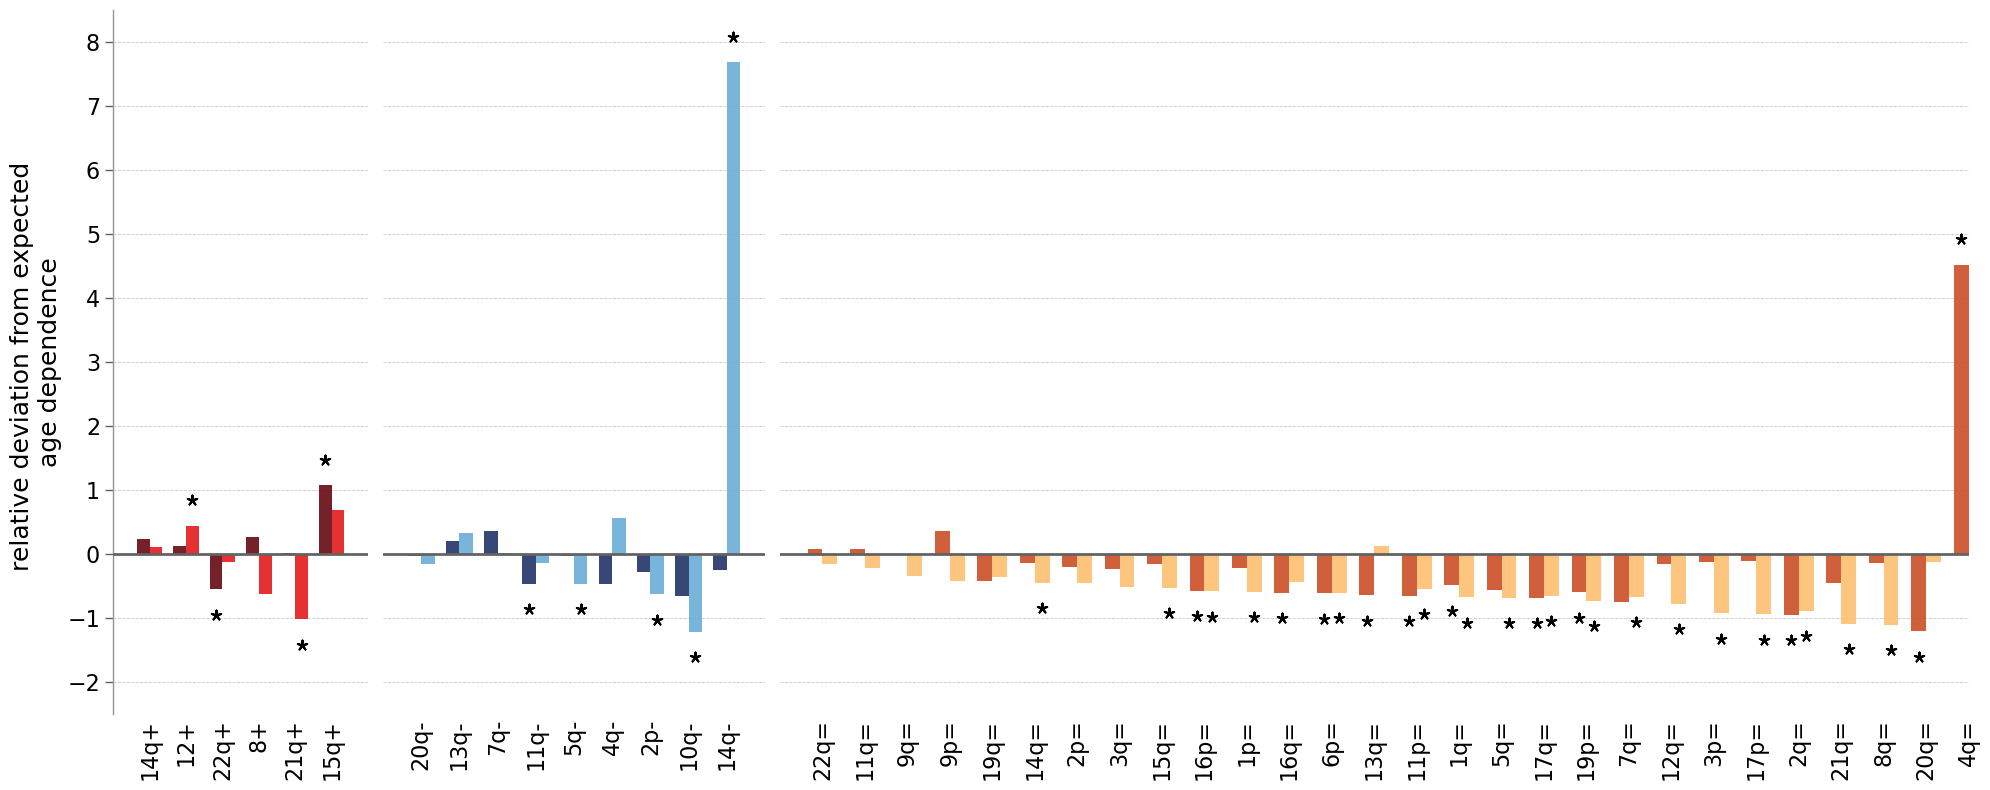

In [82]:
# Plot the deviation from the expected age dependence
fig, axes= plt.subplots(1, 3, figsize = (20, 8), sharey = True, gridspec_kw={'width_ratios': [6, 9, 28]})

ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

plot_deviation_from_expected_age_dependence('+', sorted_gradients_diff_dicts, differences_dict, ax1)
plot_deviation_from_expected_age_dependence('-', sorted_gradients_diff_dicts, differences_dict, ax2)
plot_deviation_from_expected_age_dependence('=', sorted_gradients_diff_dicts, differences_dict, ax3)

for ax in axes.flatten():
    ax.tick_params(axis='x', labelrotation = 90)
    ax.tick_params(axis = 'both', which = 'major', color = grey4)
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.spines['bottom'].set_visible(False)
    ax.grid(zorder = 0, axis = 'y')
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
ax1.set_ylabel('relative deviation from expected \nage dependence', fontsize = 18)
ax1.set_ylim(-2.5, 8.5)
ax1.set_xlim(-1, 6)
ax2.set_xlim(-1, 9)
ax3.set_xlim(-1, 27)

ax1.tick_params(axis='x', which='both',length=0)
ax2.tick_params(axis='both', which='both',length=0)
ax3.tick_params(axis='both', which='both',length=0)

ax2.spines['left'].set_visible(False)
ax3.spines['left'].set_visible(False)

ax1.plot([-1, 6], [0, 0], color = grey4, lw = 2, zorder = 60)
ax2.plot([-1, 9], [0, 0], color = grey4, lw = 2, zorder = 60)
ax3.plot([-1, 78], [0, 0], color = grey4, lw = 2, zorder = 60)
    
ax1.tick_params(axis='y', labelsize=16)
    
plt.tight_layout()
plt.savefig('Figures/Figure_3d_Deviation_from_expected_age_dependence.pdf')
plt.show()

## Can decline in prevalence with age for some mCAs be explained by acquisition of additional mCAs? (Supplementary Figure 19)

In [70]:
# Create a list of the mCAs that have the worst age dependence (i.e. negative age dependence)
negative_gradient_relative_differences = []

for mCA in gains_30_or_more+losses_30_or_more+CNLOH_30_or_more:
    gradient_relative_difference_men = differences_dict[mCA+'_male']['gradient_relative_difference']
    gradient_relative_difference_women = differences_dict[mCA+'_female']['gradient_relative_difference']
    if gradient_relative_difference_men <0:
        male_p_value = differences_dict[mCA+'_male']['p_value']
        if male_p_value<0.05:
            negative_gradient_relative_differences.append((mCA, 'M', gradient_relative_difference_men))
    if gradient_relative_difference_women <0:
        female_p_value = differences_dict[mCA+'_female']['p_value']
        if female_p_value<0.05:
            negative_gradient_relative_differences.append((mCA, 'F', gradient_relative_difference_women))
    
negative_gradient_relative_differences_sorted = sorted(negative_gradient_relative_differences, key=lambda item: item[2])

In [69]:
#Calculate the deviation in age dependence when allowing additional mCAS
gradients_dict_multimCAs = {}
gradients_multi_relative_dif_dict = {}
for (mCA, sex, gradient) in negative_gradient_relative_differences_sorted:
    fmin = mCA_specfic_fmin(mCA, df_single_mCAs)
    
    grid_lims = grid_limits_multimCAs(mCA, sex)
    age_dep = observed_expected_heatmaps_confidence_intervals_p_values_custom_range_multimCAs(mCA, df_biobank, sex_specific_s_mu_dict, fmin, sex, grid_lims)

    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    
    if sex == 'M':
        sex_written = 'male'
    if sex == 'F':
        sex_written = 'female'

    mCA_deviation_results_multimCAs = open('Data_files/mCA_age_dependence_deviation_with_additional_mCAs.txt', 'a') #'a' means append to the file, rather than overwrite it
    mCA_deviation_results_multimCAs.write(dt_string+'\t'+mCA+'\t'+sex_written+'\t'+str(age_dep['expected_gradient'])+'\t'+str(age_dep['observed_gradient'])+'\t'+
                                str(age_dep['gradient_difference'])+'\t'+str(age_dep['gradient_relative_difference'])+'\t'+
                                str(age_dep['lower_CI_difference'])+'\t'+str(age_dep['upper_CI_difference'])+'\t'+str(age_dep['p_value'])+'\n')
    mCA_deviation_results_multimCAs.close()
    
    gradients_dict_multimCAs[mCA]={}
    gradients_dict_multimCAs[mCA][sex_written]=age_dep    
    gradients_multi_relative_dif_dict[mCA]=abs(age_dep['gradient_relative_difference'])

In [72]:
#import data for each mCA (or use data from dictionary above)
differences_multi = pd.read_csv('Data_files/mCA_age_dependence_deviation_with_additional_mCAs.txt', sep = '\t')
differences_multi['mCA_sex']=differences_multi['mCA']+'_'+differences_multi['sex']
differences_multi = differences_multi.set_index('mCA_sex')
differences_multi_dict = pd.DataFrame.to_dict(differences_multi, orient = 'index')

In [73]:
#create a dictionary of relative differences for each mCA (where the stored relative difference is the largest of the male and female for that mCA)
gradients_multi_relative_difference_dict = {}
for k, v in differences_multi_dict.items():
    mCA = v['mCA']
    sex = v['sex']
    gradient_relative_difference = abs(v['gradient_relative_difference'])
    if mCA in gradients_multi_relative_difference_dict.keys():
        other_sex_result = gradients_multi_relative_difference_dict[mCA]
        gradients_multi_relative_difference_dict[mCA]=max([gradient_relative_difference, other_sex_result])
    else:
        gradients_multi_relative_difference_dict[mCA]=gradient_relative_difference

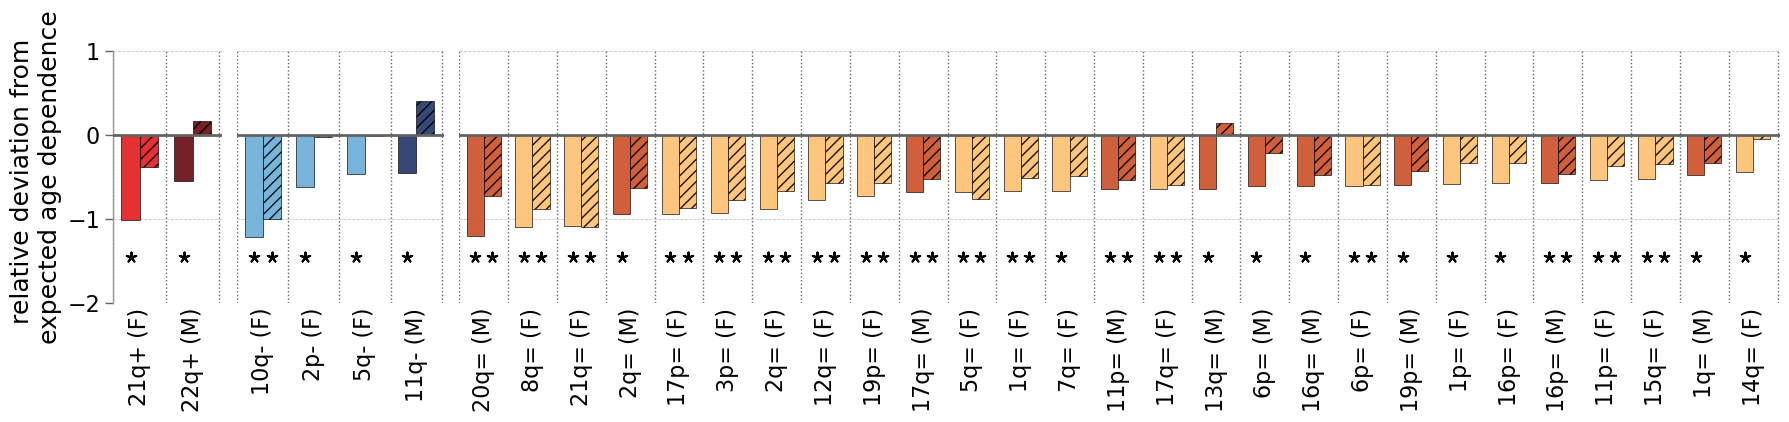

In [76]:
# Plot the deviation from the expected age dependence - sort according to the original sorting (as for a single mCA)
fig, axes= plt.subplots(1, 3, figsize = (18, 4), sharey = True, gridspec_kw={'width_ratios': [2.1, 4, 25.5]})

ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

def plot_age_dep(mCA_type, negative_gradient_relative_differences_sorted, differences_multi_dict, ax):
    x = []
    colors = []
    y1 = []
    y2 = []
    sigy1 = []
    sigy2 = []
    sigx1 = []
    sigx2 = []
    
    n=0
    for (mCA, sex, neg_diff) in negative_gradient_relative_differences_sorted:
        if mCA[-1]==mCA_type:
#             print(mCA)
            x.append(mCA+' ('+sex+')')
            if sex == 'M':
                multi_relative_difference_gradient = differences_multi_dict[mCA+'_male']['gradient_relative_difference']
                multi_p_value = differences_multi_dict[mCA+'_male']['p_value']
                single_relative_difference_gradient = differences_dict[mCA+'_male']['gradient_relative_difference']
                single_p_value = differences_dict[mCA+'_male']['p_value']
                y1.append(single_relative_difference_gradient)
                y2.append(multi_relative_difference_gradient)
                colors.append(colors_dict_mCAs[mCA[-1]]['male'])
                if single_p_value <0.05:
                    sigy1.append(single_relative_difference_gradient-0.4)
                    sigx1.append(n-(0.35/2))
                if multi_p_value <0.05:
                    sigy2.append(multi_relative_difference_gradient-0.4)
                    sigx2.append(n+(0.35/2))
            if sex == 'F':
                multi_relative_difference_gradient = differences_multi_dict[mCA+'_female']['gradient_relative_difference']
                multi_p_value = differences_multi_dict[mCA+'_female']['p_value']            
                single_relative_difference_gradient = differences_dict[mCA+'_female']['gradient_relative_difference']
                single_p_value = differences_dict[mCA+'_female']['p_value']
                y1.append(single_relative_difference_gradient)
                y2.append(multi_relative_difference_gradient)
                colors.append(colors_dict_mCAs[mCA[-1]]['female'])
                if single_p_value <0.05:
                    sigy1.append(single_relative_difference_gradient-0.4)
                    sigx1.append(n-(0.35/2))
                if multi_p_value <0.05:
                    sigy2.append(multi_relative_difference_gradient-0.4)
                    sigx2.append(n+(0.35/2))
            n+=1
            
    width = 0.35
    x_vals = []
    for a, b in enumerate(x):
        x_vals.append(a) #convert mCA to a number
        
    ax.bar([(x1 - width/2)-0 for x1 in x_vals], y1, width, label='single mCA', color = colors, alpha = 0.9, zorder = 50, edgecolor = 'k', lw =0.5)
    bars2 = ax.bar([(x1 + width/2)+0 for x1 in x_vals], y2, width, label='including multiple mCAs', color = colors, alpha = 0.9, zorder = 50, edgecolor = 'k', lw =0.5)
#     ax.scatter(sigx1, sigy1, s = 50, marker = (5, 2, 0), color = 'k', zorder = 50)
#     ax.scatter(sigx2, sigy2, s = 50, marker = (5, 2, 0), color = 'k', zorder = 50)
    
    ax.scatter(sigx1, [-1.45 for i in sigy1], s = 50, marker = (5, 2, 0), color = 'k', zorder = 50)
    ax.scatter(sigx2, [-1.45 for i in sigy2], s = 50, marker = (5, 2, 0), color = 'k', zorder = 50)
    
    for patch in bars2.patches:
        patch.set_hatch('///')

    ax.set_xticks(x_vals)
    ax.set_xticklabels(x, fontsize = 16)
    
    return ax
    
plot_age_dep('+', negative_gradient_relative_differences_sorted, differences_multi_dict, ax1)
plot_age_dep('-', negative_gradient_relative_differences_sorted, differences_multi_dict, ax2)
plot_age_dep('=', negative_gradient_relative_differences_sorted, differences_multi_dict, ax3)

for ax in axes.flatten():
    ax.tick_params(axis='x', labelrotation = 90)
    ax.tick_params(axis = 'both', which = 'major', color = grey4)
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.spines['bottom'].set_visible(False)
    ax.grid(zorder = 0, axis = 'y')
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
ax1.set_ylabel('relative deviation from \nexpected age dependence', fontsize = 18)
ax1.set_ylim(-2, 1)
ax1.set_xlim(-0.5, 1.55)
ax2.set_xlim(-0.5, 3.55)
ax3.set_xlim(-0.5, 26.55)

ax1.tick_params(axis='x', which='both',length=0)
ax2.tick_params(axis='both', which='both',length=0)
ax3.tick_params(axis='both', which='both',length=0)

ax2.spines['left'].set_visible(False)
ax3.spines['left'].set_visible(False)


for i in range(0, 3):
    ax1.plot([i-0.5, i-0.5], [-2, 1], color = grey4, lw = 1, linestyle = ':')
for i in range(0, 6):
    ax2.plot([i-0.5, i-0.5], [-2, 1], color = grey4, lw = 1, linestyle = ':')
for i in range(0, 28):
    ax3.plot([i-0.5, i-0.5], [-2, 1], color = grey4, lw = 1, linestyle = ':')

ax1.plot([-0.5, 5.5], [0, 0], color = grey4, lw = 2, zorder = 60)
ax2.plot([-0.5, 8.5], [0, 0], color = grey4, lw = 2, zorder = 60)
ax3.plot([-0.5, 77.5], [0, 0], color = grey4, lw = 2, zorder = 60)
    
ax1.tick_params(axis='y', labelsize=16)
    
plt.tight_layout()
plt.savefig('Figures/Supplement_deviation_from_expected_age_dependence_for_at_least_1_mCA.pdf')
plt.show()